<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Thanks for taking the time to improve the project! Now it's perfect! The project is accepted. Keep up the good work on the next sprint! :)

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, but there are a couple of problems in the modeling section which need to be fixed before the project is accepted. Let me know if you have any questions!

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
!pip install -qq catboost

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import random

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate
 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor, Pool 
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor

from IPython.display import display


In [3]:
df = pd.read_csv('/datasets/car_data.csv')

In [4]:
def percent_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")
        
def get_info(df):
    """
    This function uses the head(), info(), describe(), shape() and duplicated() 
    methods to display the general information about the dataset.
    """
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns with nulls:')
    display(percent_na(df, 4)) 
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")
    print()

Overview of the dataframe:

In [5]:
get_info(df)

----------------------------------------------------------------------------------------------------
Head:



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCo

None

----------------------------------------------------------------------------------------------------
Describe:



,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


----------------------------------------------------------------------------------------------------


,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,15470,8,2,250,7,40,2,109,18592
top,05/03/2016 14:25,sedan,manual,golf,petrol,volkswagen,no,03/04/2016 00:00,07/04/2016 07:16
freq,66,91457,268251,29232,216352,77013,247161,13719,654



Columns with nulls:
Column VehicleType has 10.5794% percent of Nulls, and 37490 of nulls
Column Gearbox has 5.5967% percent of Nulls, and 19833 of nulls
Column Model has 5.5606% percent of Nulls, and 19705 of nulls
Column FuelType has 9.2827% percent of Nulls, and 32895 of nulls
Column NotRepaired has 20.0791% percent of Nulls, and 71154 of nulls
There are 5 columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(354369, 16)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 262 duplicated rows.




### Summary 
Looking over the data I can see that the data have 354369 rows 16 collumns. 5 of the collumns contain NaN values, because these columns will be utilized in our model building process I will find the best way to fill them without compromising the integrity of the data. There are also 262 duplicate rows, column names which are in capital letters, and data types which should be changed to more appropriate types

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

#### Column names
I will change the column names to snake case. 

In [6]:
df = df.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox',
       'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand',
       'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice!
    

</div>

#### Missing Values
I will inspect the details of the missing values to help me assess and choose the best way to fill them

In [7]:
def missing_values_table(df):
       
        mis_val = df.isnull().sum()
        
        
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        
        return mis_val_table_ren_columns

In [8]:
missing_values_table(df)

Your selected dataframe has 16 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
not_repaired,71154,20.1
vehicle_type,37490,10.6
fuel_type,32895,9.3
gearbox,19833,5.6
model,19705,5.6


The column 'not_repaired' contains 20% NaN. This is significant. I believe it is a default answer. i.e. when the entry is made if it is 'not_repaired' the entry was left blank instead of entered as 'Yes'. I could go off of this assumption but because I cannot say for sure, I will fill the NaN in this case with a new option 'unknown'. For the rest I will fill using a function based on the model. I will fill the model based off of the brand.

In [9]:
def replace_missing_value(unique_value_feature, col_to_replace):  
    """
    This function is used to replace missing value in a column
    using possible unique value feature for those missing values    
    """
    # get unique value of feature from this dataframe
    for value in df[unique_value_feature].unique().tolist():
        # get specific value of features using possible value from column value to replace
        specific_value_df = df[df[unique_value_feature] == value].dropna()[col_to_replace]    
        value_replacement_list = specific_value_df.unique().tolist()
        # for the missing value, assign a random choice of the replacement value for that unknown value
        if value_replacement_list != []:
            df.loc[(df[unique_value_feature] == value) & (df[col_to_replace] != df[col_to_replace]), col_to_replace] = random.choice(value_replacement_list)
        else:
            df.loc[(df[unique_value_feature] == value) & (df[col_to_replace] != df[col_to_replace]), col_to_replace] = df[col_to_replace].mode() 

In [10]:
replace_missing_value('brand', 'model')

In [11]:
replace_missing_value('model', 'vehicle_type')

In [12]:
replace_missing_value('model', 'fuel_type')

In [13]:
replace_missing_value('model', 'gearbox')

In [14]:
df['not_repaired'].fillna('unknown', inplace=True)
df.not_repaired.value_counts()

no         247161
unknown     71154
yes         36054
Name: not_repaired, dtype: int64

In [15]:
missing_values_table(df)

Your selected dataframe has 16 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
model,3374,1.0
gearbox,1104,0.3
fuel_type,1104,0.3
vehicle_type,1042,0.3


for the remaining NaN I have the option to drop them but I believe it will be better to replace the 'NaN' with the entry 'unknown'

In [16]:
df.fillna(value='unknown', inplace=True)

In [17]:
missing_values_table(df)

Your selected dataframe has 16 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


<div class="alert alert-success">
<b>Reviewer's comment</b>

Missing values were dealt with reasonably!

</div>

### Dealing with the Duplicates
Next I will drop the duplicated rows from the data

In [18]:
df = df.drop_duplicates()

In [19]:
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354102.000000,354102.000000,354102.000000,354102.000000,354102.000000,354102.0,354102.000000
mean,4416.417202,2004.235345,110.089596,128211.984118,5.714139,0.0,50507.118486
std,4514.333007,90.261803,189.916207,37906.730492,3.726660,0.0,25784.252508
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good!

</div>

#### Changing the Datatypes
I will adjust the datatypes of the date containing columns to 'datetime64[ns]' and the integer containing columns to int32 to decrease memory usage.

In [20]:
def change_datatype(df, cols, type_val):
    for col in cols:
        df[col] = df[col].astype(type_val)
        
change_datatype(df, ['date_crawled', 'date_created', 'last_seen'], 'datetime64[ns]')
change_datatype(df, ['price', 'registration_year', 'power', 'registration_month', 'number_of_pictures'], 'int32')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354102 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354102 non-null  datetime64[ns]
 1   price               354102 non-null  int32         
 2   vehicle_type        354102 non-null  object        
 3   registration_year   354102 non-null  int32         
 4   gearbox             354102 non-null  object        
 5   power               354102 non-null  int32         
 6   model               354102 non-null  object        
 7   mileage             354102 non-null  int64         
 8   registration_month  354102 non-null  int32         
 9   fuel_type           354102 non-null  object        
 10  brand               354102 non-null  object        
 11  not_repaired        354102 non-null  object        
 12  date_created        354102 non-null  datetime64[ns]
 13  number_of_pictures  354102 no

### Engineering the Feature:Age
I will create this feature to help me detect outliers so I can clean up my dataset of any data that may squew the modeling process downstream.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice feature!

</div>

In [22]:
df['age'] = df['date_created'].dt.year - df['registration_year']
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen,age
0,2016-03-24 11:52:00,480,wagon,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-07-04 03:16:00,23
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,80,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00,5
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-05-04 12:47:00,12
3,2016-03-17 16:54:00,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:00,15
4,2016-03-31 17:25:00,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-06-04 10:17:00,8


### Exploratory Data Analysis

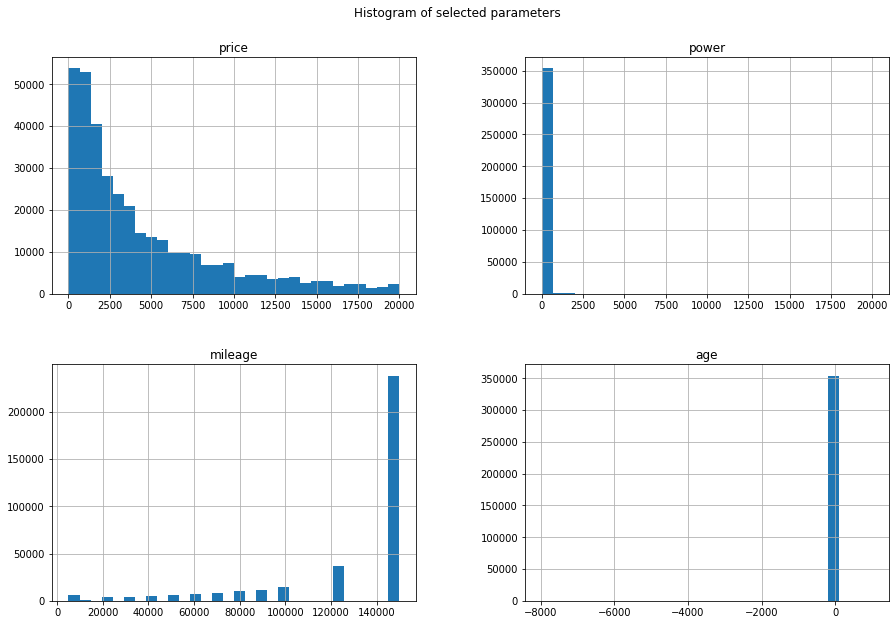

In [23]:
df[['price', 'power', 'mileage', 'age']].hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogram of selected parameters', y=0.95);

These histograms show me that most cars are sold at the 0-7500 euro price range. Now lets remove any outliers. I will remove any vehilcle with horsepower less than 2039 because anything below that does not actually exist, same with vehicles with ages in the negative numbers. 


In [24]:
df_filtered = df[(df['power'] <= 2039) & (df['age'] >= 0)]
print(f'The shape of the new dataset is: {df_filtered.shape}')
print()
df_filtered.describe()

The shape of the new dataset is: (339475, 17)



,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code,age
count,339475.000000,339475.000000,339475.000000,339475.000000,339475.000000,339475.0,339475.000000,339475.000000
mean,4470.825109,2002.322619,108.436291,128066.440828,5.754798,0.0,50604.676147,13.677302
std,4546.363192,13.952596,72.160321,37926.774105,3.708757,0.0,25808.139053,13.952606
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000,0.000000
25%,1099.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30169.000000,9.000000
50%,2799.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49492.000000,13.000000
75%,6500.000000,2007.000000,143.000000,150000.000000,9.000000,0.0,71229.000000,17.000000
max,20000.000000,2016.000000,2018.000000,150000.000000,12.000000,0.0,99998.000000,1016.000000


### Conclusion
the dataset is now cleaned up. NaN values were dealt with, column names were made uniform, data types were corrected, and outliers were removed. The next step is model training. 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very good!

</div>

## Model training
First we will create dataset removing the unnecessary columns. Then I will make the training test and validation sets, as well as encode the categorical features using OHE and check over the data before we get started.  

In [25]:
categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [26]:
car_df = df_filtered.drop(['date_crawled', 'registration_year', 'registration_month','date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

features = car_df.drop(['price'],axis=1)

target = car_df.price

<div class="alert alert-success">
<b>Reviewer's comment</b>

The list of dropped columns makes sense

</div>

In [27]:
features = features.fillna('NaN')

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339475 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   vehicle_type  339475 non-null  object
 1   gearbox       339475 non-null  object
 2   power         339475 non-null  int32 
 3   model         339475 non-null  object
 4   mileage       339475 non-null  int64 
 5   fuel_type     339475 non-null  object
 6   brand         339475 non-null  object
 7   not_repaired  339475 non-null  object
 8   age           339475 non-null  int64 
dtypes: int32(1), int64(2), object(6)
memory usage: 24.6+ MB


In [28]:
ohe = pd.get_dummies(data = features, columns = categorical, drop_first=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(ohe, target, test_size=.25, random_state=12345)
features_valid_ohe,features_test_ohe,target_valid_ohe, target_test_ohe=train_test_split(features_test_ohe,target_test_ohe, test_size=.125, random_state=12345)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=12345)
features_valid, features_test, target_valid, target_test= train_test_split(features_test, target_test, test_size=.125, random_state=12345)

print('features_train_ohe size:', features_train_ohe.shape[0])
print('features_test_ohe size:', features_test_ohe.shape[0])
print('features_valid_ohe size:', features_valid_ohe.shape[0])
print('target_train_ohe size:', target_train_ohe.shape[0])
print('target_test_ohe size:', target_test_ohe.shape[0])
print('target_valid_ohe size:', target_valid_ohe.shape[0])

print()
print('features_train size:', features_train.shape[0])
print('features_test size:', features_test.shape[0])
print('features_valid size:', features_valid.shape[0])
print('target_train size:', target_train.shape[0])
print('target_test size:', target_test.shape[0])
print('target_valid size:', target_valid.shape[0])

features_train_ohe size: 254606
features_test_ohe size: 10609
features_valid_ohe size: 74260
target_train_ohe size: 254606
target_test_ohe size: 10609
target_valid_ohe size: 74260

features_train size: 254606
features_test size: 10609
features_valid size: 74260
target_train size: 254606
target_test size: 10609
target_valid size: 74260


<div class="alert alert-success">
<b>Reviewer's comment</b>

Categorical features were encoded. The data was split into train, validation and test sets

</div>

In [29]:
#scale numerics
numerics = ['power','mileage']
#scale
scaler = StandardScaler()
scaler.fit(features_train_ohe[numerics])

features_train[numerics] = scaler.transform(features_train[numerics])
features_valid[numerics] = scaler.transform(features_valid[numerics])
features_test[numerics] = scaler.transform(features_test[numerics])

features_train_ohe[numerics] = scaler.transform(features_train_ohe[numerics])
features_valid_ohe[numerics] = scaler.transform(features_valid_ohe[numerics])
features_test_ohe[numerics] = scaler.transform(features_test_ohe[numerics])

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Looks like your forgot to scale the validation set

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Fixed!

</div>

In [30]:
#new dataframe to for the model analysis
model_data = pd.DataFrame(columns=('model','fit_time','score_time','RMSE'))
model_data.head()

,model,fit_time,score_time,RMSE


### Linear Regression for Sanity Check
The first model to test is linear regression as our sanity check. This is a way to indicate if our models are actually improving the outcomes or not. 

In [31]:
def rmse(y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    return mse**.5

In [32]:
#create model
model = LinearRegression()

#create dataframe row
lr_data = ['Linear Regression']

#fit model and save time
start = time.time()
model.fit(features_train_ohe, target_train_ohe)
end=time.time()

#add time to row
lr_data.append(end-start)

#predict and save time
start = time.time()
prediction = model.predict(features_valid_ohe)
end=time.time()

#add time to row
lr_data.append(end-start)

#calculate RMSE
lr_rmse = rmse(target_valid_ohe, prediction)

#add to row
lr_data.append(lr_rmse)

model_data.loc[len(model_data)] = lr_data
model_data.head()

,model,fit_time,score_time,RMSE
0,Linear Regression,24.688118,0.1372,3073.533226


though the model and scoring times are quick the RMSE of 3068 gives us room for improvement 

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

This seems like a result of different scales of train and validation sets

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Great!

</div>

### Random Forest Regressor
Lets try a tree based model and see if we can get a better score. 

In [33]:
#create model
rf_model = RandomForestRegressor(random_state=12345, n_estimators=10)

#create dataframe row
rf_data = ['Random Forest']

#fit model and save time
start = time.time()
rf_model.fit(features_train_ohe, target_train_ohe)
end=time.time()

#add time to row
rf_data.append(end-start)

#predict and save time
start = time.time()
prediction = rf_model.predict(features_valid_ohe)
end=time.time()

#add time to row
rf_data.append(end-start)

#calculate RMSE
rf_rmse = rmse(target_valid_ohe, prediction)

#add to row
rf_data.append(rf_rmse)

model_data.loc[len(model_data)] = rf_data
model_data.head()

,model,fit_time,score_time,RMSE
0,Linear Regression,24.688118,0.137200,3073.533226
1,Random Forest,52.560357,0.497972,1770.515887


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

If you want to do cross-validation, that's great, but please make sure that:
    
1. The models are evaluated consistently: either use cross-validation for all models or use the validation set for all models
2. Cross-validation should not be done on the whole dataset: we still need a separate test set to evaluate the final model for an unbiased estimate of its generalization performance. So the correct way is to do cross-validation on the train set. This applies to all instances of cross-validation in this project, not just the above.

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Alright, both problems were fixed!

</div>

RMSE=1782 that is an improvement. Next we will try with hyperparameter tuning. 

### Random Forest Hyperparameter Tuning 

In [34]:
grid = {
    "n_estimators" : [10, 25, 50],
    "max_depth" : [None, 2, 4, 8],
    "min_samples_leaf" : [2, 4, 6]
}
# define the model 
regressor = RandomForestRegressor(random_state = 12345)
# define the grid search
grid_search_rf = GridSearchCV(estimator = regressor, param_grid = grid, scoring="neg_mean_squared_error", cv=3)
# execute search
grid_search_rf.fit(X=features_train_ohe, y=target_train_ohe)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_rf.best_params_))

The best hyperparameters are: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 50}


In [35]:
#create model
rf_ht_model = RandomForestRegressor(**grid_search_rf.best_params_)

#create dataframe row
rf_ht_data = ['Random Forest with Hyperparameters']

#fit model and save time
start = time.time()
rf_ht_model.fit(features_train_ohe, target_train_ohe)
end=time.time()

#add time to row
rf_ht_data.append(end-start)

#predict and save time
start = time.time()
prediction = rf_ht_model.predict(features_valid_ohe)
end=time.time()

#add time to row
rf_ht_data.append(end-start)

#calculate RMSE
rf_ht_rmse = rmse(target_valid_ohe, prediction)

#add to row
rf_ht_data.append(rf_ht_rmse)

model_data.loc[len(model_data)] = rf_ht_data
model_data.head()

,model,fit_time,score_time,RMSE
0,Linear Regression,24.688118,0.137200,3073.533226
1,Random Forest,52.560357,0.497972,1770.515887
2,Random Forest with Hyperparameters,238.175680,1.736716,1718.868541


a small improvement but a large increase in time. 

### LightGBM

In [49]:
import warnings
warnings.filterwarnings('ignore')

for column in categorical:
    features_train[column] = features_train[column].astype('category')
    features_valid[column] = features_valid[column].astype('category')
    features_test[column] = features_test[column].astype('category')

In [37]:
lgb = LGBMRegressor()

#create parameters for feature tuning
param = {
        'num_leaves': [10, 31],
    'learning_rate': [.01,.5],
    'max_depth': [-1,5]
}

#pass parameters necessary for cross validation
gs = GridSearchCV(estimator=lgb,param_grid=param,scoring='neg_mean_squared_error')

#fit model
start = time.time()
lgb_model = gs.fit(X=features_train, y=target_train)
end=time.time()

print(lgb_model.best_params_, lgb_model.best_score_)
print('The best hyperparameters are: {}'.format(gs.best_params_))

{'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 31} -3060408.7441985123
The best hyperparameters are: {'learning_rate': 0.5, 'max_depth': -1, 'num_leaves': 31}


In [38]:

#create dataframe row
lgb_data = ['LightGBM']

#add time to row
lgb_data.append(end-start)

#predict and save time
start = time.time()
prediction = lgb_model.predict(features_valid)
end=time.time()

#add time to row
lgb_data.append(end-start)

#calculate RMSE
lgb_rmse = rmse(target_valid, prediction)

#add to row
lgb_data.append(lgb_rmse)

model_data.loc[len(model_data)] = lgb_data
model_data.head(10)

,model,fit_time,score_time,RMSE
0,Linear Regression,24.688118,0.137200,3073.533226
1,Random Forest,52.560357,0.497972,1770.515887
2,Random Forest with Hyperparameters,238.175680,1.736716,1718.868541
3,LightGBM,484.066604,0.592504,1734.854643


### CatBoost

In [39]:

cat_features = [
    'vehicle_type', 
    'gearbox', 
    'model', 
    'fuel_type', 
    'brand', 
    'not_repaired',
]

In [40]:
#create model
cb_model = CatBoostRegressor(
    cat_features=cat_features,
    random_state = 12345)

#create dataframe row
cb_data = ['CatBoost Regressor']

#fit model and save time
start = time.time()
cb_model.fit(features_train, target_train, cat_features=cat_features,
             eval_set=(features_valid, target_valid), verbose=False, plot=False)
end=time.time()

#add time to row
cb_data.append(end-start)

#predict and save time
start = time.time()
prediction = cb_model.predict(features_valid)
end=time.time()

#add time to row
cb_data.append(end-start)

#calculate RMSE
cb_rmse = rmse(target_valid, prediction)

#add to row
cb_data.append(cb_rmse)

model_data.loc[len(model_data)] = cb_data
model_data.head(7)

,model,fit_time,score_time,RMSE
0,Linear Regression,24.688118,0.137200,3073.533226
1,Random Forest,52.560357,0.497972,1770.515887
2,Random Forest with Hyperparameters,238.175680,1.736716,1718.868541
3,LightGBM,484.066604,0.592504,1734.854643
4,CatBoost Regressor,554.359254,0.866123,1725.521247


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

1. Please use the same split as for other models
2. The test set should not be used as the eval_set for early stopping (you can use the validation set instead)
3. The model should not be evaluated on the test set unless it is the final model (or we won't be able to get an unbiased estimate of the final model's generalization performance)

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Very good!
    

</div>

### XGBoost 

In [41]:
xgb_model = XGBRegressor(random_state = 12345)
xgb_model.fit(features_train_ohe, target_train_ohe) 
    

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
#create model
xgb_model = XGBRegressor(random_state = 12345)

#create dataframe row
xgb_data = ['XGBoost']

#fit model and save time
start = time.time()
xgb_model.fit(features_train_ohe, target_train_ohe)
end=time.time()

#add time to row
xgb_data.append(end-start)

#predict and save time
start = time.time()
prediction = xgb_model.predict(features_valid_ohe)
end=time.time()

#add time to row
xgb_data.append(end-start)

#calculate RMSE
xgb_rmse = rmse(target_valid_ohe, prediction)

#add to row
xgb_data.append(xgb_rmse)

model_data.loc[len(model_data)] = xgb_data
model_data.head(10)

,model,fit_time,score_time,RMSE
0,Linear Regression,24.688118,0.137200,3073.533226
1,Random Forest,52.560357,0.497972,1770.515887
2,Random Forest with Hyperparameters,238.175680,1.736716,1718.868541
3,LightGBM,484.066604,0.592504,1734.854643
4,CatBoost Regressor,554.359254,0.866123,1725.521247
5,XGBoost,477.900700,1.182771,1767.409857


## Model Evaluation

''

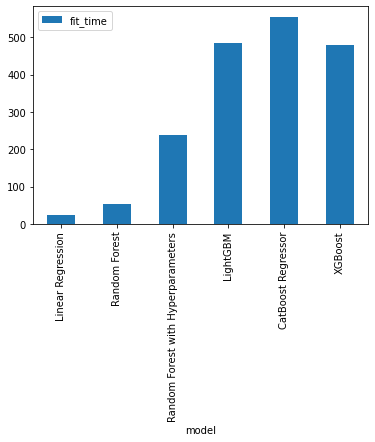

In [43]:
model_data = model_data.drop_duplicates()
model_data.plot.bar(x='model',y='fit_time')
;

''

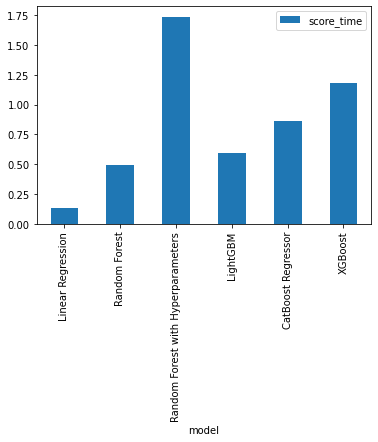

In [44]:
model_data.plot.bar(x='model',y='score_time')
;

''

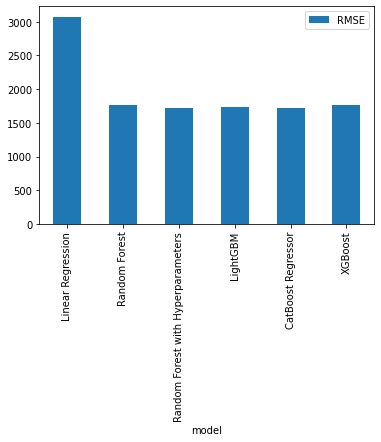

In [47]:
model_data.plot.bar(x='model',y='RMSE')
;

### Final Test

In [52]:
lgb_data_final = ['LightGBM Final Test']

#predict and save time
start = time.time()
prediction = lgb_model.predict(features_test)
end=time.time()

#add time to row
lgb_data_final.append(end-start)

#calculate RMSE
lgb_rmse_final = rmse(target_test, prediction)

#add to row
lgb_data_final.append(lgb_rmse_final)

print('LightGBM Final Test scores: ', 'score_time: ', end-start, 'RMSE: ', lgb_rmse_final)


LightGBM Final Test scores:  score_time:  0.07635188102722168 RMSE:  1731.8916762864062


# Conclusion

Our client, Rusty Bargain, has tasked us with finding a model that can optimize time in training and prediction, and accuracy of results. After testing 6 different models I have some data that I think is useful. The sanity check linear regression returned an extremly high RMSE. The tree based algorithm showed a dramatic improvement in scoreing which improved minorly with hyperparameter tuning. The gradient boosting model, LightGBM, was used with hyperparameter tuning. The RMSE was not better than that of the other models but the training and prediction times were significantly reduced. I recommend Rusty Bargain move forward with LightGBM as their model for predicting the price of customer used cars.

<div class="alert alert-success">
<b>Reviewer's comment</b>

It's great that you tried different models, tuned their hyperparameters using cross-validation and took both RMSE and fit/predict times when analyzing the models' performance

</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Don't forget to evaluate the final selected model on the test set for an unbiased estimate of its generalization performance

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Excellent!

</div>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed